## Predição da Safra de 2020 | SciCrop

<br>

Neste Notebook será utilizado Machine Learning, mais especificamente Classificação* para prever o dano na safra de 2020 baseados nas informações abaixo:

<br><br>

*Foi escolhido a Classificação porque o resultado a ser previsto é categórico (1,2,3) e não quantitativo, como por exemplo, o número de insetos.

<br>

| Variável                 | Descrição                                                    |
| ------------------------ | ------------------------------------------------------------ |
| Identificador_Agricultor | IDENTIFICADOR DO CLIENTE                                     |
| Estimativa_de_Insetos    | Estimativa de insetos por M²                                 |
| Tipo_de_Cultivo          | Classificação do tipo de cultivo (0,1)                       |
| Tipo_de_Solo             | Classificação do tipo de solo (0,1)                          |
| Categoria_Pesticida      | Informação do uso de pesticidas (1- Nunca Usou, 2-Já Usou, 3-Esta usando) |
| Doses_Semana             | Número de doses por semana                                   |
| Semanas_Utilizando       | Número de semanas Utilizada                                  |
| Semanas_Sem_Uso          | Número de semanas sem utilizar                               |
| Temporada                | Temporada Climática (1,2,3)                                  |
| dano_na_plantacao        | Variável de Predição - Dano no Cultivo (0=Sem Danos, 1=Danos causados por outros motivos, 2=Danos gerados pelos pesticidas) |


Este notebook está dividido nas seguintes partes:

<br>
    
    1. Setup do environment
    2. EDA (Exploratory Data Analysis)
    3. Limpando e organizando os dados (caso seja necessário)
    4. Criação do Modelo de Predição
    5. Tunando os Hiperparâmetros
    6. Métricas de Avaliação
    7. Visualizando Category Importance
    8. Visualizando a predição 

### 1. Setup do environment

In [1]:
# Ferramentas básicas
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

%matplotlib inline

In [21]:
# Modelos
import xgboost as xgb

from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import train_test_split

In [ ]:
# Avalição

In [3]:
# Importando os dados
Safra_18_19 = pd.read_csv('Safra_2018-2019.csv', index_col = 0)
Safra_20    = pd.read_csv('Safra_2020.csv', index_col = 0)

# Visualizando a tabela
Safra_18_19.columns

Index(['Identificador_Agricultor', 'Estimativa_de_Insetos', 'Tipo_de_Cultivo',
       'Tipo_de_Solo', 'Categoria_Pesticida', 'Doses_Semana',
       'Semanas_Utilizando', 'Semanas_Sem_Uso', 'Temporada',
       'dano_na_plantacao'],
      dtype='object')

### 2. EDA ( Exploratory Data Analysis)

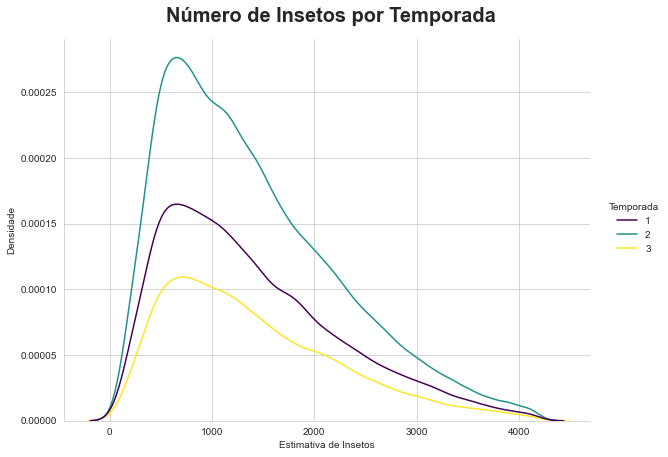

In [5]:
# Visualizando a correlação entre o número de insetos e a estação do ano
sns.set_style('whitegrid')

plot = sns.displot( x        = Safra_18_19.Estimativa_de_Insetos,
                    hue      = Safra_18_19.Temporada, 
                    kind     = 'kde',
                    height   = 6, 
                    aspect   = 11.7/8.27,
                    palette  = 'viridis')

plot.fig.suptitle('Número de Insetos por Temporada',
                   y          = 1.05,
                   fontsize   = 20, 
                   fontweight = 'bold')

plot.set(xlabel = 'Estimativa de Insetos',
         ylabel = 'Densidade')

plt.show()

Como podemos ver no gráfico acima, apesar da distribuição de insetos por temporada seguirem a mesma tendência, é possível ver que a Temporada 2 é a que tem o maior número de insetos, seguido pela Temporada 1 e depois a Temporada 3.

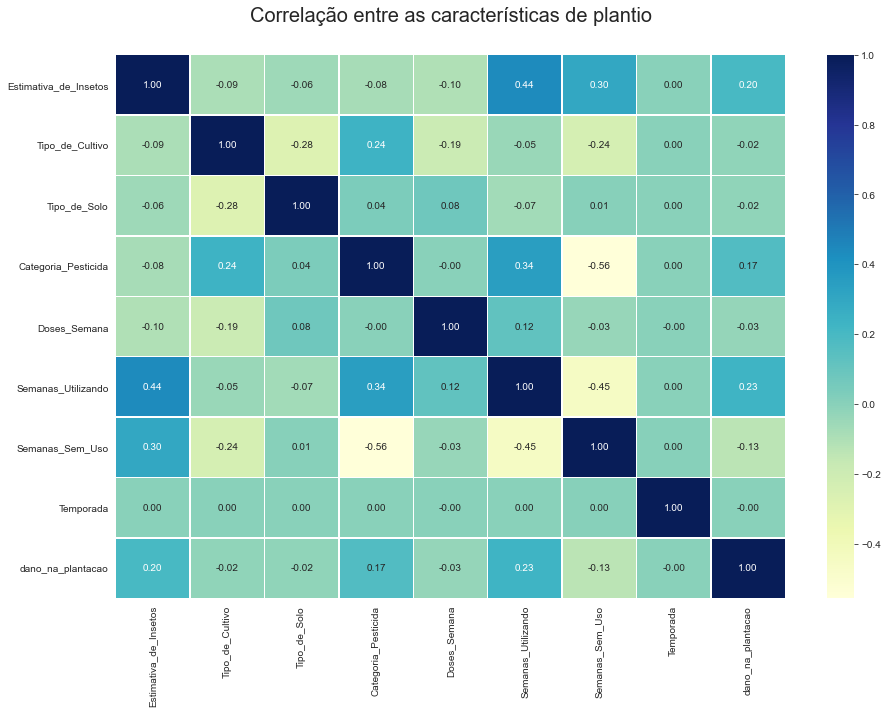

In [6]:
# Visualizando a correlação entre as características de plantio

corr_matrix = Safra_18_19.corr()

fig, ax = plt.subplots(figsize = (15,10))

ax = sns.heatmap(corr_matrix,
                annot      = True,
                linewidths = 0.5,
                fmt        = '.2f',
                cmap       = 'YlGnBu')

plt.title('Correlação entre as características de plantio', 
          size = 20, 
          y    = 1.05);

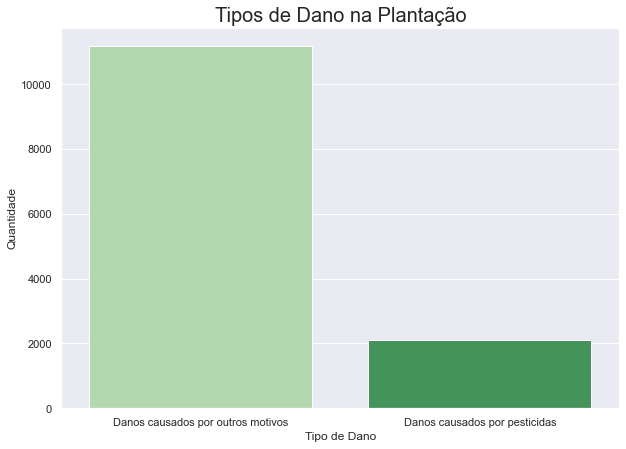

In [5]:
# Visualizando o dano quantitativamente
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(10,7)})

plot = sns.countplot(palette = 'Greens',
                     x       = Safra_18_19.dano_na_plantacao,
                     order   = [1,2])

plot.set(xlabel = 'Tipo de Dano',
         ylabel = 'Quantidade',
         xticklabels = ['Danos causados por outros motivos', 'Danos causados por pesticidas'])

plt.title('Tipos de Dano na Plantação', size = 20);

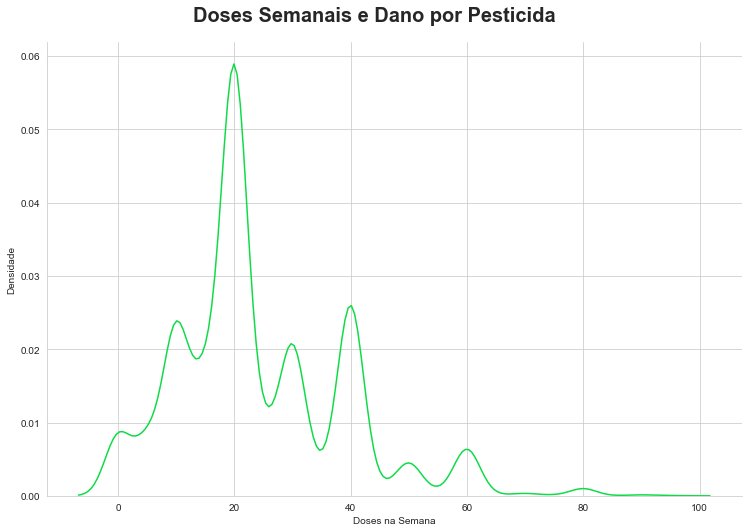

In [7]:
# Visualizando a relação entre Doses por semanas, Dano na Plantação e 
sns.set_style('whitegrid')

plot = sns.displot(Safra_18_19.Doses_Semana[Safra_18_19.dano_na_plantacao == 1], 
                   label  = 'Dano Por Pesticida',
                   color  = '#0fdb46',
                   kind   = 'kde',
                   height = 7,
                   aspect = 1.5)

plot.fig.suptitle('Doses Semanais e Dano por Pesticida',
                   y          = 1.05,
                   fontsize   = 20, 
                   fontweight = 'bold')

plot.set(xlabel = 'Doses na Semana',
         ylabel = 'Densidade')

plt.show()

### 3. Limpando e organizando os dados (caso seja necessário)

<br>

Será julgado que é necessário limpar e organizar caso:

<br>

1. O dados não estejam organizados.
2. Tenha dado faltando.
3. Existam dados categóricos.
4. Algum dado esteja no formato errado (ex.: `str`, `int`).

#### 3.1 O dados não estejam organizados.

<br>

Os dados estão organizados corretamente, logo não há a necessidade de mudar isso.

#### 3.2 Tenha dado faltando.

In [8]:
(Safra_18_19.isna().sum()/len(Safra_18_19))*100

Identificador_Agricultor     0.00000
Estimativa_de_Insetos        0.00000
Tipo_de_Cultivo              0.00000
Tipo_de_Solo                 0.00000
Categoria_Pesticida          0.00000
Doses_Semana                 0.00000
Semanas_Utilizando          10.06875
Semanas_Sem_Uso              0.00000
Temporada                    0.00000
dano_na_plantacao            0.00000
dtype: float64

Ok, aproximadamente 10% das Semanas Utilizando estão sem informações, isso se deve provavelmente porque o agricultor não utiliza pesticidas, por isso vamos ver se há a relação de Semanas sem Uso = NaN (sem informação) e Categoria de Pesticida = 0 (nunca usou).

In [9]:
Safra_18_19.Semanas_Utilizando.isna().sum()

8055

In [10]:
len(Safra_18_19[Safra_18_19.Categoria_Pesticida == 1])

763

Como podemos ver, existem mais casos onde as informações das Semanas estão faltando do que a Categoria de Pesticida é 1.

<br>
O que será feito é descobrir quais são as que estão relacionadas a nunca ter usado o pesticida. O resto será colocado a média das Semanas Utilizando.

In [11]:
combined = [Safra_18_19, Safra_20] 

for dataset in combined:
    
    mean = dataset.Semanas_Utilizando.mean()
    
    dataset.Semanas_Utilizando = np.where((dataset.Semanas_Utilizando.isna()) & 
                                              (dataset.Categoria_Pesticida == 1),0, 
                                              mean)

# Checkando a modificação
Safra_20.Semanas_Utilizando.isna().sum()

0

In [12]:
# Checando se ainda há alguma informação faltando
Safra_18_19.isna().sum()

Identificador_Agricultor    0
Estimativa_de_Insetos       0
Tipo_de_Cultivo             0
Tipo_de_Solo                0
Categoria_Pesticida         0
Doses_Semana                0
Semanas_Utilizando          0
Semanas_Sem_Uso             0
Temporada                   0
dano_na_plantacao           0
dtype: int64

#### 3.3 Existam dados categóricos.

<br>

No caso de dados categóricos, é melhor dividir em colunas. Isso será feito em ambas planilhas de 2018-2019 e 2020, uma vez que na hora prever baseado nos dados de 2020, as planilhas precisam estar nos mesmos moldes.

<br><br>

OBS: Dados Categóricos são os que dividem os dados em categorias, no nosso caso, são esses:

<br>

Apesar de ter `dano_na_plantacao` ter característica categórica, ela não será categorizada devido ao fato de ser a variável a ser prevista.

<br><br>

| Variável                 | Descrição                                                    |
| ------------------------ | ------------------------------------------------------------ |
| Tipo_de_Cultivo          | Classificação do tipo de cultivo (0,1)                       |
| Tipo_de_Solo             | Classificação do tipo de solo (0,1)                          |
| Categoria_Pesticida      | Informação do uso de pesticidas (1- Nunca Usou, 2-Já Usou, 3-Esta usando) |
| Temporada                | Temporada Climática (1,2,3)                                  |

<br>

In [13]:
'''Por algum motivo a função concat do Pandas não funciona em list comprehensions,
   por isso fiz separadamente'''

dummies_Tipo_de_Cultivo = pd.get_dummies(Safra_18_19.Tipo_de_Cultivo, 
                                         prefix     = 'Tipo_de_Cultivo', 
                                         prefix_sep = '_')

dummies_Tipo_de_Solo = pd.get_dummies(Safra_18_19.Tipo_de_Solo, 
                                      prefix     = 'Tipo_de_Solo', 
                                      prefix_sep = '_')

dummies_Categoria_Pesticida = pd.get_dummies(Safra_18_19.Categoria_Pesticida, 
                                             prefix     = 'Categoria_Pesticida', 
                                             prefix_sep = '_')

dummies_Temporada = pd.get_dummies(Safra_18_19.Temporada,
                                   prefix     = 'Temporada',
                                   prefix_sep = '_')

# Tirando as colunas originais (já que não se fazem mais necessárias)
Safra_18_19.drop('Tipo_de_Cultivo', axis = 1, inplace = True)
Safra_18_19.drop('Tipo_de_Solo', axis = 1, inplace = True)
Safra_18_19.drop('Categoria_Pesticida', axis = 1, inplace = True)
Safra_18_19.drop('Temporada', axis = 1, inplace = True)

# Juntando as novas colunas ao DataFrame
Safra_18_19 = pd.concat([Safra_18_19,
                         dummies_Tipo_de_Cultivo,
                         dummies_Tipo_de_Solo,
                         dummies_Categoria_Pesticida,
                         dummies_Temporada], axis = 1)

In [18]:
dummies_Tipo_de_Cultivo = pd.get_dummies(Safra_20.Tipo_de_Cultivo, 
                                         prefix     = 'Tipo_de_Cultivo', 
                                         prefix_sep = '_')

dummies_Tipo_de_Solo = pd.get_dummies(Safra_20.Tipo_de_Solo, 
                                      prefix     = 'Tipo_de_Solo', 
                                      prefix_sep = '_')

dummies_Categoria_Pesticida = pd.get_dummies(Safra_20.Categoria_Pesticida, 
                                             prefix     = 'Categoria_Pesticida', 
                                             prefix_sep = '_')

dummies_Temporada = pd.get_dummies(Safra_20.Temporada,
                                   prefix     = 'Temporada',
                                   prefix_sep = '_')


# Tirando as colunas originais (já que não se fazem mais necessárias)
Safra_20.drop('Tipo_de_Cultivo', axis = 1, inplace = True)
Safra_20.drop('Tipo_de_Solo', axis = 1, inplace = True)
Safra_20.drop('Categoria_Pesticida', axis = 1, inplace = True)
Safra_20.drop('Temporada', axis = 1, inplace = True)

# Juntando as novas colunas ao DataFrame
Safra_20 = pd.concat([Safra_20,
                         dummies_Tipo_de_Cultivo,
                         dummies_Tipo_de_Solo,
                         dummies_Categoria_Pesticida,
                         dummies_Temporada], axis = 1)

In [14]:
# Checkando as mudanças
Safra_18_19.columns

Index(['Identificador_Agricultor', 'Estimativa_de_Insetos', 'Doses_Semana',
       'Semanas_Utilizando', 'Semanas_Sem_Uso', 'dano_na_plantacao',
       'Tipo_de_Cultivo_0', 'Tipo_de_Cultivo_1', 'Tipo_de_Solo_0',
       'Tipo_de_Solo_1', 'Categoria_Pesticida_1', 'Categoria_Pesticida_2',
       'Categoria_Pesticida_3', 'Temporada_1', 'Temporada_2', 'Temporada_3'],
      dtype='object')

In [19]:
# Checkando as mudanças
Safra_20.columns

Index(['Identificador_Agricultor', 'Estimativa_de_Insetos', 'Doses_Semana',
       'Semanas_Utilizando', 'Semanas_Sem_Uso', 'Tipo_de_Cultivo_0',
       'Tipo_de_Cultivo_1', 'Tipo_de_Solo_0', 'Tipo_de_Solo_1',
       'Categoria_Pesticida_1', 'Categoria_Pesticida_2',
       'Categoria_Pesticida_3', 'Temporada_1', 'Temporada_2', 'Temporada_3'],
      dtype='object')

#### 3.4 Algum dado esteja no formato errado (ex.: `str`, `int`).

In [16]:
Safra_18_19.dtypes

Identificador_Agricultor     object
Estimativa_de_Insetos         int64
Doses_Semana                  int64
Semanas_Utilizando          float64
Semanas_Sem_Uso               int64
dano_na_plantacao             int64
Tipo_de_Cultivo_0             uint8
Tipo_de_Cultivo_1             uint8
Tipo_de_Solo_0                uint8
Tipo_de_Solo_1                uint8
Categoria_Pesticida_1         uint8
Categoria_Pesticida_2         uint8
Categoria_Pesticida_3         uint8
Temporada_1                   uint8
Temporada_2                   uint8
Temporada_3                   uint8
dtype: object

In [20]:
Safra_20.dtypes

Identificador_Agricultor     object
Estimativa_de_Insetos         int64
Doses_Semana                  int64
Semanas_Utilizando          float64
Semanas_Sem_Uso               int64
Tipo_de_Cultivo_0             uint8
Tipo_de_Cultivo_1             uint8
Tipo_de_Solo_0                uint8
Tipo_de_Solo_1                uint8
Categoria_Pesticida_1         uint8
Categoria_Pesticida_2         uint8
Categoria_Pesticida_3         uint8
Temporada_1                   uint8
Temporada_2                   uint8
Temporada_3                   uint8
dtype: object

Apesar do Identificador do Agricultor não ser levado em conta na hora da previsão, ele precisa estar em formato numérico, por isso vou retirar 'SCROP' e depois colocá-lo novamente. Eu poderia tirar a coluna inteira depois da divisão entre treino e teste (que embaralha as linhas) mas seria arriscado, uma vez que o XGBoost também o faz ( somente em subsampling). 

In [36]:
Safra_18_19.Identificador_Agricultor = Safra_18_19.Identificador_Agricultor.str.replace('SCROP', '').astype(int)
Safra_20.Identificador_Agricultor = Safra_20.Identificador_Agricultor.str.replace('SCROP', '').astype(int)

AttributeError: Can only use .str accessor with string values!

In [37]:
Safra_18_19.dtypes

Identificador_Agricultor      int32
Estimativa_de_Insetos         int64
Doses_Semana                  int64
Semanas_Utilizando          float64
Semanas_Sem_Uso               int64
dano_na_plantacao             int64
Tipo_de_Cultivo_0             uint8
Tipo_de_Cultivo_1             uint8
Tipo_de_Solo_0                uint8
Tipo_de_Solo_1                uint8
Categoria_Pesticida_1         uint8
Categoria_Pesticida_2         uint8
Categoria_Pesticida_3         uint8
Temporada_1                   uint8
Temporada_2                   uint8
Temporada_3                   uint8
dtype: object

Como podemos ver, todas as colunas são do tipo numericas `int` ou `float` ( para decimais).

### 4. Criação do Modelo de Predição

<br>

Aqui será utilizado os seguintes modelos devido à sua eficiência para problemas de Classificação (que é o caso):

* XGBoost Random Forest Classifier
* XGBoost Classifier
* Logistic Regression
* Random Forest Classifier

<br>

Depois serão analisados os resultados e os modelos com a maior acurácia terão seus hiperparâmetros ajustados.

In [39]:
# Dividindo entre X e y
X, y = Safra_18_19.drop('dano_na_plantacao', axis = 1), Safra_18_19.dano_na_plantacao

# Dividindo entre Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

# Put Models in a dictionary
models = {'Logistic Regression': LogisticRegression(),
          'XGBoost Random Forest': xgb.XGBRFClassifier(),
          'XGBoost Classifier': xgb.XGBClassifier(),
          'Random Forest': RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    '''
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn machine learning models.
    x_train: training data ( no labels)
    x_test: test data (no labels)
    y_train: training labels
    y_test: test labels
    '''
    
    # Make a dict to keep model scores
    model_scores = {}
    
    # Loop through models
    for name, model in models.items():
        
        # Fit the model to the data
        model.fit(X_train,y_train)
        
        #Evaluates the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
        
    return model_scores

model_scores = fit_and_score(models  = models,
                             X_train = X_train,
                             X_test  = X_test,
                             y_train = y_train,
                             y_test  = y_test)
model_scores


C:\Users\erica\Downloads\Tools\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\erica\Downloads\Tools\Anaconda\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:01:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'Logistic Regression': 0.8317916666666667,
 'XGBoost Random Forest': 0.8375,
 'XGBoost Classifier': 0.8371666666666666,
 'Random Forest': 0.819625}